### Precursor: postage stamp plot 
aka the Super position of forced signal and internal variability: Total
should look like 50 year trends of KGP for each ensemble member

see this notebook: https://github.com/NCAR/ncar-python-tutorial/blob/master/notebooks/workflows/cesm/oxygen-trend-computation/O2_forced_unforced.ipynb

## Figure 2: explicit signal decomposition

* take the two ensemble members from the postage stamp plot, one where natural variability is amplifying and one where it's dampening
* make the two row three column plot showing the decomposition of the total trend in each of those ensemble members.

##### Using the DJF prospective trends:
* Plot internal var and forced trend the two ensembles 
* Plot a replicate of the total signal where you are doing: this total signal is equal to this natural variability component plus this forced trend component.



In [1]:
%matplotlib inline
import os
import shutil

from itertools import product
import xpersist as xp
from glob import glob

import numpy as np
import xarray as xr

import pop_tools
import intake

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.path as mpath
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean

import util

In [2]:
ds_prosp = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf-prospective-trends.zarr')
ds_prosp

ValueError: group not found at path ''

## If all you need is a solo trend plot, this will work - the rest is below:

In [85]:
v = 'SST'
unit = '°C'#'mg m$^{3}$' #'mm day$^{-1}$'
tl = 50
ty = 2020
l = 40
dur = ty + tl


trend = ds_prosp[v].sel(trend_length = tl, trend_year = ty) #, length = l )

dsp = util.pop_add_cyclic(
    xr.Dataset({
        'trend': trend,
        'TLAT': trend.TLAT.compute(),
        'TLONG': trend.TLONG.compute()
    } ))

forced = dsp.trend.mean('member_id').compute()
forced

<xarray.DataArray 'trend' (nlat: 93, nlon: 321)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    trend_length  int64 50
    trend_year    int64 2020
Dimensions without coordinates: nlat, nlon

In [86]:
print('mean:', forced.mean().values)
print('min:', forced.min().values)
print('max:', forced.max().values)

mean: 0.038228409207294284
min: 0.0
max: 0.24969873909363316


In [87]:
#levels - Chl / SST
#cmap = cmocean.cm.dense
cmap = cmocean.cm.thermal
levels = np.linspace(forced.min().values, forced.max().values, 11)
levels

array([0.        , 0.02496987, 0.04993975, 0.07490962, 0.0998795 ,
       0.12484937, 0.14981924, 0.17478912, 0.19975899, 0.22472887,
       0.24969874])

In [88]:
#levels - KGP
#cmap=cmocean.cm.curl_r
#limYMin = -0.008
#limYMax = 0.008
#levels = np.linspace(limYMin, limYMax, 17) #15 for 007
#levels

In [89]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
norm = MidpointNormalize(midpoint=0.)
extent = ([-180, 180, -90, -50], ccrs.PlateCarree()) #[120, 260, 10, 65]
prj = ccrs.SouthPolarStereo()

### Define a helper function that makes a single map plot.


In [90]:
def one_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG,dsp.TLAT,da,
                     levels=levels,
                     norm=norm,
                     cmap=cmap,
                     #extend='both',
                     transform=ccrs.PlateCarree())
    # contour lines
    cs = ax.contour(dsp.TLONG,dsp.TLAT,da,
                    colors='k',
                    #levels=levels,
                    linewidths=0.5,
                    transform=ccrs.PlateCarree())
    #if lines:
        # add contour labels
    #    lb = plt.clabel(cs, fontsize=6, inline=True, fmt=r'%r \%%')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='darkgray'))

    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=0.5).n_steps = 90 

    return cf

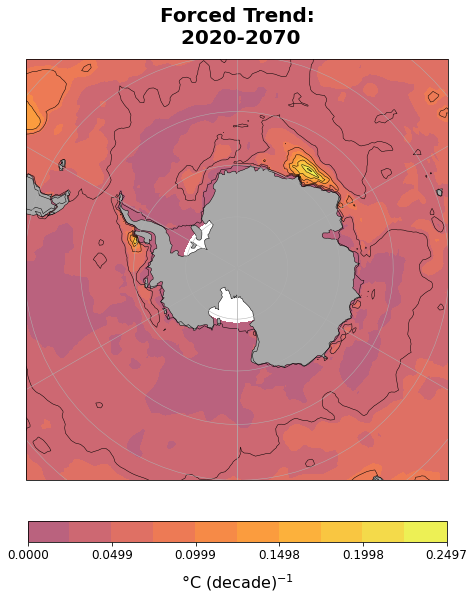

In [91]:
fig = plt.figure(figsize=(10, 10))
axs = []
ax = fig.add_subplot(1, 1, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = one_plot(forced)
ax.set_title(f'Forced Trend:\n {ty}-{dur}', pad=15, fontsize = 20, fontweight='bold') 
axs.append(ax)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal', ax=axs, pad=0.075)
cb.set_label(f'{unit}'' (decade)$^{-1}$', labelpad=10, fontsize = 16)
cb.ax.tick_params(labelsize=12)

title = (f'{v}-{ty}-{tl}')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')


## If you want the whole thing.... continue

## ID arrays you want:

In [5]:
kgptrend_20_10 = ds_prosp['KGP'].sel(trend_length = 10, trend_year = 2020, length = 40. )
kgptrend_20_20 = ds_prosp['KGP'].sel(trend_length = 20, trend_year = 2020, length = 40. )
kgptrend_20_50 = ds_prosp['KGP'].sel(trend_length = 50, trend_year = 2020, length = 40. )

kgptrend_06_10 = ds_prosp['KGP'].sel(trend_length = 10, trend_year = 2006, length = 40. )
kgptrend_06_20 = ds_prosp['KGP'].sel(trend_length = 20, trend_year = 2006, length = 40. )
kgptrend_06_50 = ds_prosp['KGP'].sel(trend_length = 50, trend_year = 2006, length = 40. )

ssttrend_20_10 = ds_prosp['SST'].sel(trend_length = 10, trend_year = 2020 )
ssttrend_20_20 = ds_prosp['SST'].sel(trend_length = 20, trend_year = 2020 )
ssttrend_20_50 = ds_prosp['SST'].sel(trend_length = 50, trend_year = 2020 )

chltrend_20_10 = ds_prosp['Chl_surf'].sel(trend_length = 10, trend_year = 2020 )
chltrend_20_20 = ds_prosp['Chl_surf'].sel(trend_length = 20, trend_year = 2020 )
chltrend_20_50 = ds_prosp['Chl_surf'].sel(trend_length = 50, trend_year = 2020 )

## Start here to reset the data you are plotting:

In [10]:
############## QUICK PLOTTING RESET Part 1 ##############
trnd_ds = kgptrend_20_20

############## QUICK PLOTTING RESET Part 2 ##############
dsp = util.pop_add_cyclic(
    xr.Dataset({
        'trend': trnd_ds,
        'TLAT': trnd_ds.TLAT.compute(),
        'TLONG': trnd_ds.TLONG.compute()
    } ))

############## QUICK PLOTTING RESET Part 3 ##############
# specify the exact EM number you want: [13,26]  [104, 10] [17,31]
test = [17,31]

# Recalc the trends
forced = dsp.trend.mean('member_id').compute()
internal = [(dsp.trend.sel(member_id=i) - forced).compute()
            #for i in member_id_pick]
            for i in test]


### Set up plotting 

In [12]:
#levels
limYMin = -0.008
limYMax = 0.008
levels = np.linspace(limYMin, limYMax, 17) #15 for 007
levels

array([-0.008, -0.007, -0.006, -0.005, -0.004, -0.003, -0.002, -0.001,
        0.   ,  0.001,  0.002,  0.003,  0.004,  0.005,  0.006,  0.007,
        0.008])

In [13]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
norm = MidpointNormalize(midpoint=0.)

extent = ([-180, 180, -90, -50], ccrs.PlateCarree()) #[120, 260, 10, 65]
prj = ccrs.SouthPolarStereo()

### Define a helper function that makes a single map plot.


In [14]:
def one_plot(da, lines=True):

    # filled contours
    cf = ax.contourf(dsp.TLONG,
                     dsp.TLAT,
                     da,
                     levels=levels,
                     norm=norm,
                     cmap=cmocean.cm.curl_r,
                     extend='both',
                     transform=ccrs.PlateCarree())

    # contour lines
    cs = ax.contour(dsp.TLONG,
                    dsp.TLAT,
                    da,
                    colors='k',
                    #levels=levels,
                    linewidths=0.5,
                    transform=ccrs.PlateCarree())

    #if lines:
        # add contour labels
    #    lb = plt.clabel(cs, fontsize=6, inline=True, fmt=r'%r \%%')

    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical',
                                            'land',
                                            '110m',
                                            facecolor='darkgray'))

    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=0.5).n_steps = 90 

    return cf


#### Make a plot showing the Total trend and it's internal and forced components for the ensemble members with the min and max


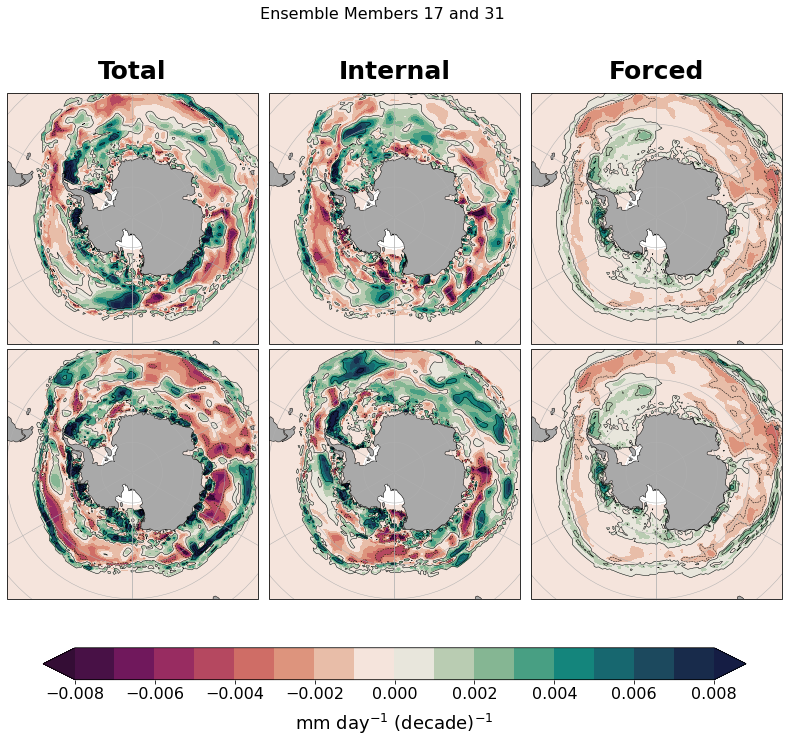

In [15]:
fig = plt.figure(figsize=(14, 12))
axs = []
plt.suptitle('Ensemble Members 17 and 31', fontsize = 16)

# plot total
ax = fig.add_subplot(2, 3, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
one_plot(dsp.trend.sel(member_id=member_id_pick[0]))
ax.set_title('Total', pad=15, fontsize = 25, fontweight='bold')
axs.append(ax)

ax = fig.add_subplot(2, 3, 4, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
one_plot(dsp.trend.sel(member_id=member_id_pick[1]))
axs.append(ax)

# plot internal variability
ax = fig.add_subplot(2, 3, 2, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
one_plot(internal[0])
ax.set_title('Internal', pad=15, fontsize = 25, fontweight='bold')
axs.append(ax)

ax = fig.add_subplot(2, 3, 5, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
one_plot(internal[1])
axs.append(ax)

# plot forced
ax = fig.add_subplot(2, 3, 3, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
one_plot(forced)
ax.set_title('Forced', pad=15, fontsize = 25, fontweight='bold') 
axs.append(ax)

ax = fig.add_subplot(2, 3, 6, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = one_plot(forced)
axs.append(ax)

# add colorbar
plt.subplots_adjust(hspace=0.02, wspace=0.02)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.9, orientation='horizontal', ax=axs, pad=0.075)
cb.set_label('mm day$^{-1}$ (decade)$^{-1}$', labelpad=10, fontsize = 18)
cb.ax.tick_params(labelsize=16)

#save figure
#plt.savefig('figures/decomp-20yr-17-31.pdf', bbox_inches='tight')

## Solo Plots!

In [43]:
v = 'KGP'
tl = 20
ty = 2020
l = 40
dur = ty + tl

trend = ds_prosp[v].sel(trend_length = tl, trend_year = ty, length = l )

dsp = util.pop_add_cyclic(
    xr.Dataset({
        'trend': trend,
        'TLAT': trend.TLAT.compute(),
        'TLONG': trend.TLONG.compute()
    } ))

forced = dsp.trend.mean('member_id').compute()


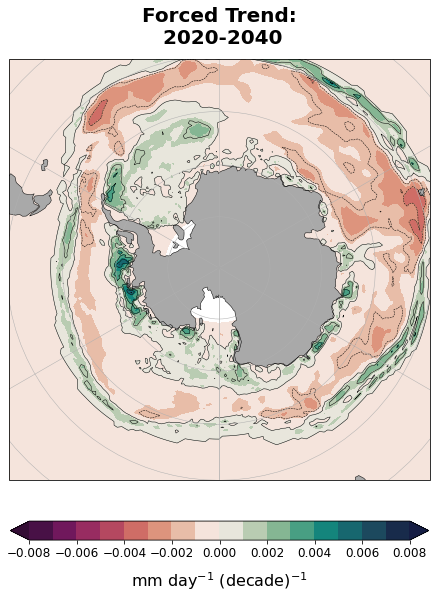

In [44]:
fig = plt.figure(figsize=(10, 10))
axs = []
ax = fig.add_subplot(1, 1, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = one_plot(forced)
ax.set_title(f'Forced Trend:\n {ty}-{dur}', pad=15, fontsize = 20, fontweight='bold') 
axs.append(ax)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal', ax=axs, pad=0.075)
cb.set_label('mm day$^{-1}$ (decade)$^{-1}$', labelpad=10, fontsize = 16)
cb.ax.tick_params(labelsize=12)

title = (f'{v}-{ty}-{tl}')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')


___
### postage stamp plot showing all the trends: 
First compute each ensemble member to load into memory.

In [43]:
field = [
    dsp.trend.isel(member_id=i).compute() for i in range(0, len(ds_prosp.member_id))
]

Text(0.5, 1.0, 'mm d$^{-1}$ decade$^{-1}$')

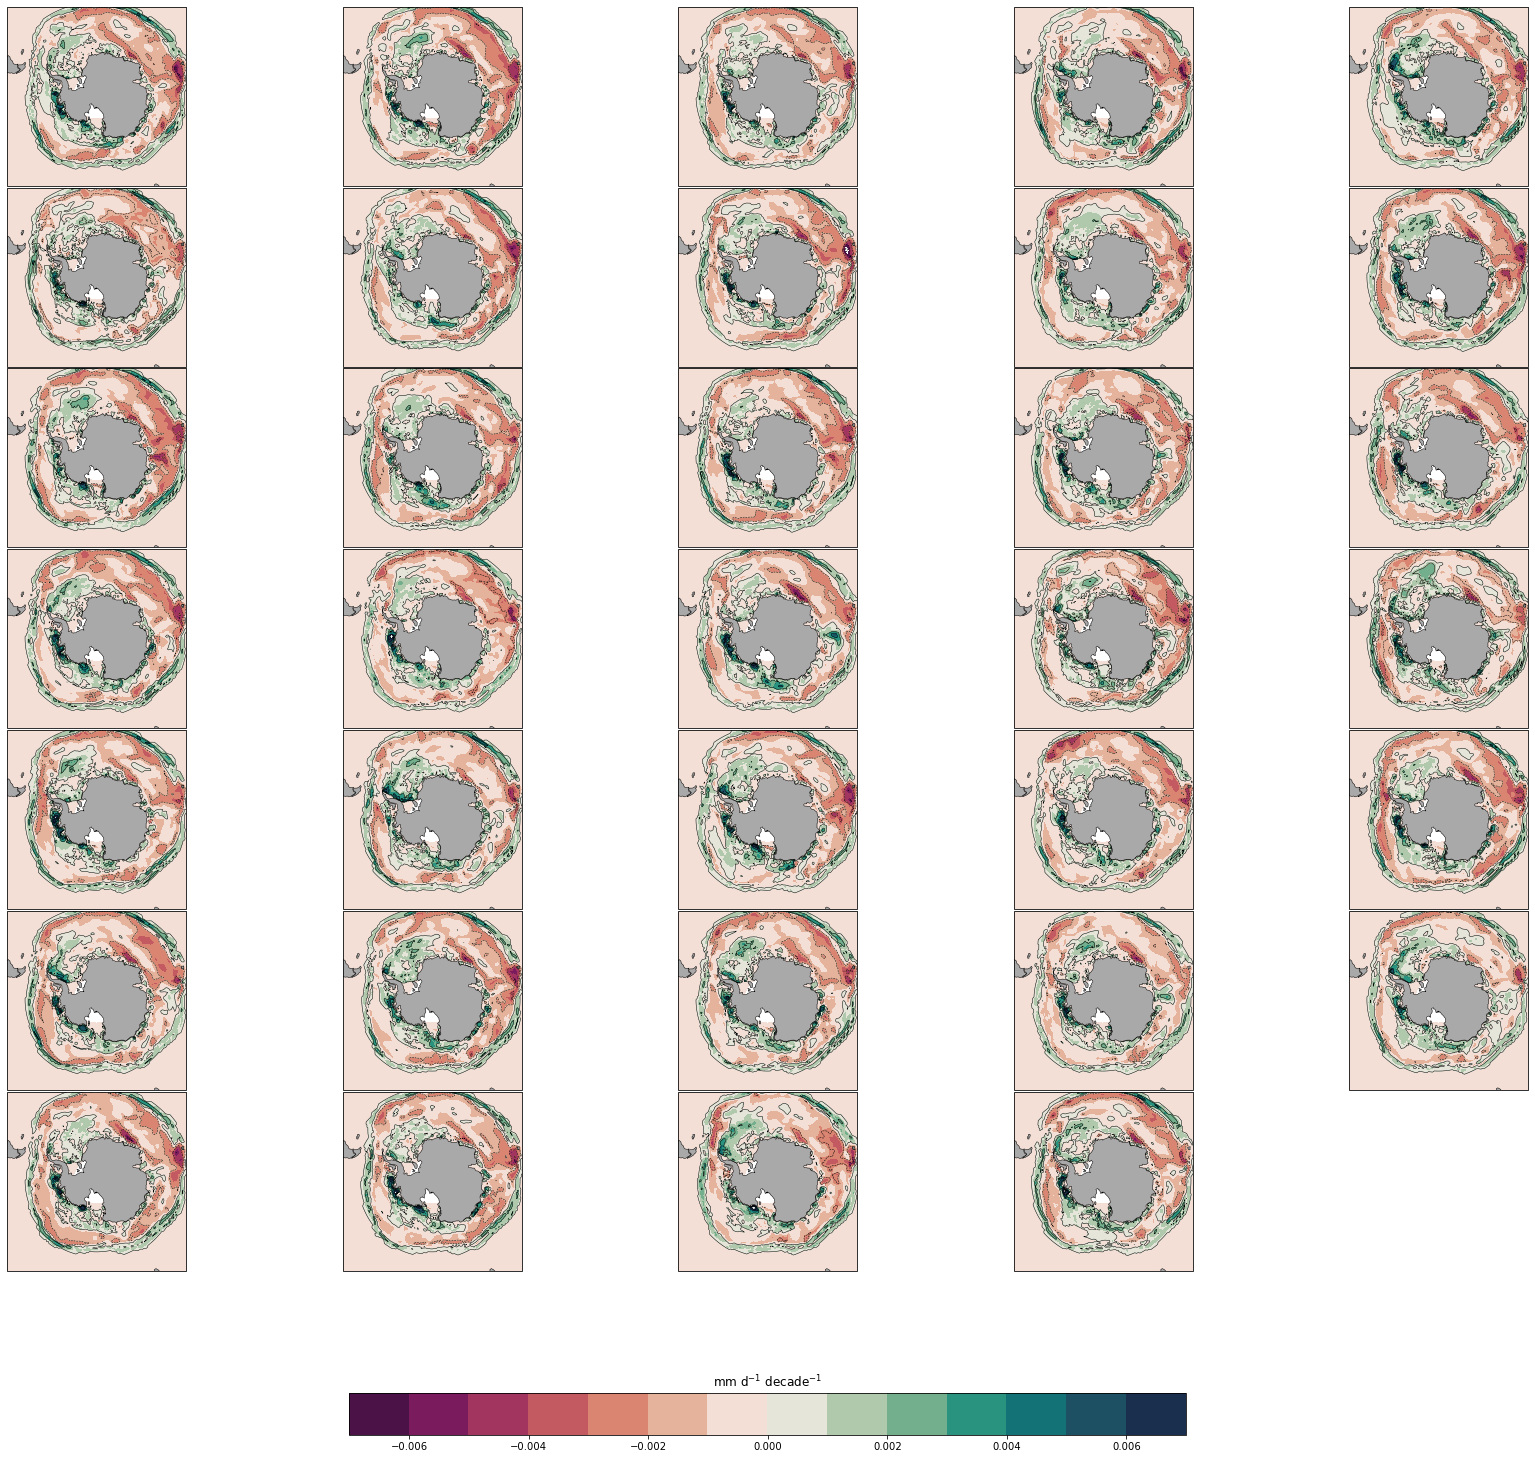

In [47]:
fig = plt.figure(figsize=(30, 30))

axs = []

# plot total
for i in range(0, len(ds_prosp.member_id)):
    ax = fig.add_subplot(7, 5, i + 1, projection=prj)
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    cf = one_plot(field[i], lines = False)
    axs.append(ax)

plt.subplots_adjust(hspace=0.01, wspace=0.01)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal', ax=axs, pad=0.075)
cb.ax.set_title(dsp.trend.units)

#plt.savefig('figures/all-trends-KGP-2006-50yr-lines-100dpi.png', dpi=100, bbox_inches='tight')

### Plot All Trends - Internal

Text(0.5, 1.0, 'mm d$^{-1}$ decade$^{-1}$')

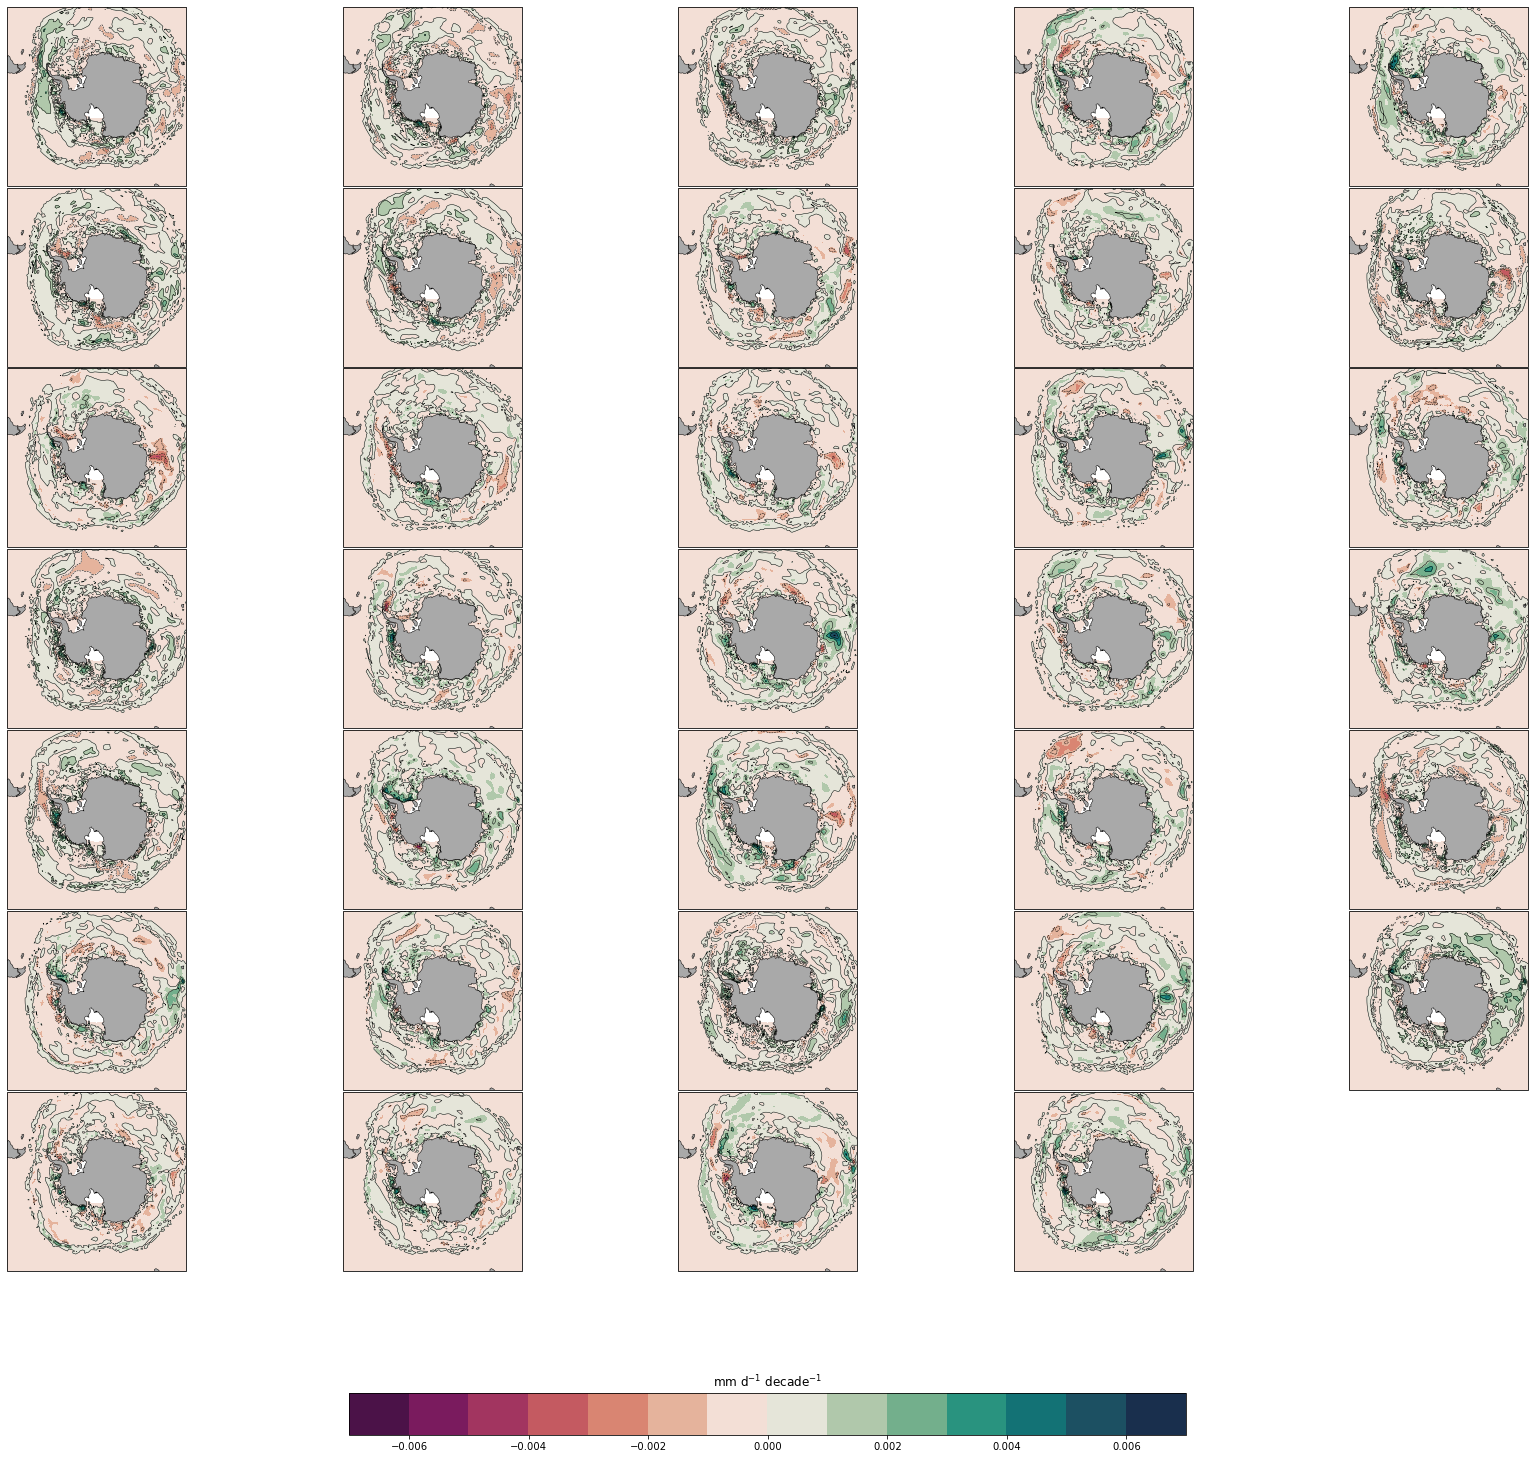

In [49]:
fig = plt.figure(figsize=(30, 30))

axs = []

# plot total
for i in range(0, len(ds_prosp.member_id)):
    ax = fig.add_subplot(7, 5, i + 1, projection=prj)
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    cf = one_plot(field[i] - forced, lines=False)
    axs.append(ax)

plt.subplots_adjust(hspace=0.01, wspace=0.01)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal', ax=axs, pad=0.075)
cb.ax.set_title(dsp.trend.units)

#plt.savefig('figures/all-trends-internal-KGP-2006-50yr-100dpi.png', dpi=100, bbox_inches='tight')